<a href="https://colab.research.google.com/github/josuebatista/PyTorchOCR/blob/main/PyTorch_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#!cd /drive/MyDrive
#!pwd
#!ls /content/drive/MyDrive/PyTorch_Coursera/Python_OCR/EnglishFnt.tgz
import tarfile
tar = tarfile.open('/content/drive/MyDrive/PyTorch_Coursera/Python_OCR/EnglishFnt.tgz')
tar.extractall('./EnglishFnt')
tar.close()

In [4]:
data = torchvision.datasets.ImageFolder(
    root='./EnglishFnt/English/Fnt',
    transform=transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

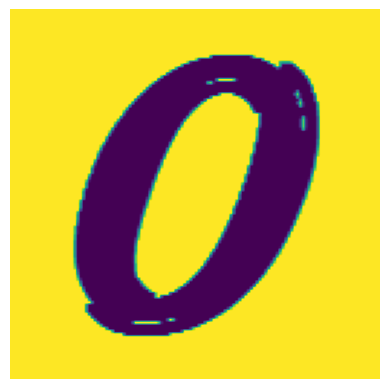

torch.Size([1, 1, 48, 48])


In [5]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load and display the image
image_path = '/content/EnglishFnt/English/Fnt/Sample001/img001-00012.png'  # Replace with the path to your actual image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
preprocessed_image = preprocess(image)

# Add a batch dimension
input_tensor = preprocessed_image.unsqueeze(0)

# Verify the shape of the input tensor
print(input_tensor.shape)

In [6]:
def load_split(dataset, batch_size, test_split=0.3, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(test_split * dataset_size))
    train_indices, test_indices = indices[split:], indices[:split]

    testset_size = len(test_indices)
    indices = list(range(testset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(0.5 * testset_size))
    val_indices, test_indices = indices[split:], indices[:split]

    # Creating data samplers:
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    # Creating data loaders:
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=test_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=val_sampler)

    return train_loader, test_loader, val_loader

In [7]:
batch_size = 36
train_loader, test_loader, val_loader = load_split(data, batch_size, test_split=0.3)

In [8]:
for batch in train_loader:
    images, labels = batch
    print(images.shape)  # Print the shape of the batch of images
    print(labels.shape)  # Print the shape of the batch of labels
    break  # Print only the first batch

torch.Size([36, 3, 48, 48])
torch.Size([36])


In [15]:
class OCRNet(nn.Module):
    def __init__(self, num_features):
        super(OCRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(num_features, 62)  # Output has 62 classes instead of 10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

num_features = 32 * 48 * 48  # Adjust this value based on the actual feature size
model = OCRNet(num_features)

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [17]:
def train(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Call the training function
train(model, train_loader, optimizer, criterion, num_epochs=10)



Epoch 1/10, Loss: 1.6279
Epoch 2/10, Loss: 0.9571
Epoch 3/10, Loss: 0.7714
Epoch 4/10, Loss: 0.6585
Epoch 5/10, Loss: 0.5798
Epoch 6/10, Loss: 0.5191
Epoch 7/10, Loss: 0.4614
Epoch 8/10, Loss: 0.4190
Epoch 9/10, Loss: 0.3851
Epoch 10/10, Loss: 0.3492


In [18]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

validate(model, val_loader, criterion)

Validation Loss: 0.2243, Validation Accuracy: 94.05%


In [20]:
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

test(model, test_loader, criterion)

Test Loss: 0.2403, Test Accuracy: 93.63%


In [21]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/PyTorch_Coursera/Python_OCR/PyTorch_OCR_20230613a.pth')

In [38]:
# Load model
model = OCRNet(num_features)
model.load_state_dict(torch.load('/content/drive/MyDrive/PyTorch_Coursera/Python_OCR/PyTorch_OCR_20230613a.pth'))
model.eval()  # Ensure the model is in evaluation mode

OCRNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=73728, out_features=62, bias=True)
)

tensor([19])


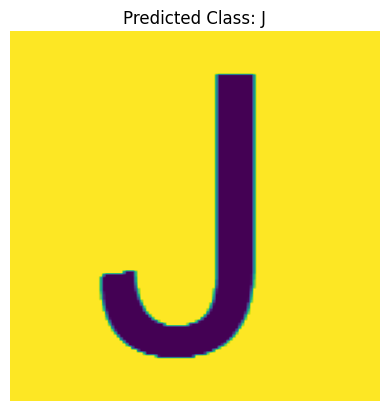

In [48]:
#classes = list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789')
classes = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')

def predict(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = transform(image).unsqueeze(0)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image)
        _, predicted_idx = torch.max(output, 1)
        print(predicted_idx)
        predicted_class = classes[predicted_idx]

    plt.imshow(Image.open(image_path))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Specify the path to your image
image_path = '/content/EnglishFnt/English/Fnt/Sample020/img020-00250.png'
#image_path = '/content/downloadA.png'

predict(model, image_path, preprocess)
